In [11]:
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import statsmodels.api as sm
from sklearn.metrics import r2_score
from prophet import Prophet

In [12]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = (30,6)
matplotlib.rcParams['axes.titlesize']= 20

In [13]:
def mapperDictGenerator(df, label):
  d= dict()
  factorized= pd.factorize(df[label])
  for i, _ in enumerate(factorized[1]):
    d[i]= _
  return factorized[0], d

In [14]:
df=pd.read_csv('data/MCI_2014_to_2019.csv')
df.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,...,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-79.405228,43.656982,7801,GO-20152165447,2015-12-18T03:58:00.000Z,2015-12-18T03:59:00.000Z,Commercial,1430,100,Assault,...,352.0,Friday,3,Assault,D14,79,University (79),-79.405228,43.656982,7001
1,-79.307907,43.778732,7802,GO-20151417245,2015-08-15T21:45:00.000Z,2015-08-17T22:11:00.000Z,Commercial,1430,100,Assault,...,227.0,Saturday,21,Assault,D42,118,Tam O'Shanter-Sullivan (118),-79.307907,43.778732,7002
2,-79.225029,43.765942,7803,GO-20151421107,2015-08-16T16:00:00.000Z,2015-08-18T14:40:00.000Z,Apartment,2120,200,B&E,...,228.0,Sunday,16,Break and Enter,D43,137,Woburn (137),-79.225029,43.765942,7003
3,-79.140823,43.778648,7804,GO-20152167714,2015-11-26T13:00:00.000Z,2015-12-18T13:38:00.000Z,Other,2120,200,B&E,...,330.0,Thursday,13,Break and Enter,D43,133,Centennial Scarborough (133),-79.140823,43.778648,7004
4,-79.288361,43.691235,7805,GO-20152169954,2015-12-18T19:50:00.000Z,2015-12-18T19:55:00.000Z,Commercial,1430,100,Assault,...,352.0,Friday,19,Assault,D55,61,Taylor-Massey (61),-79.288361,43.691235,7005


In [15]:
df.describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Hood_ID,Long,Lat,ObjectId
count,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000,206376.000000,206376.000000,206376.000000,206435.000000,206435.000000,206435.000000,206435.000000,206435.000000
mean,-79.394940,43.707379,103218.000000,1696.667755,145.973953,2016.619323,15.746855,187.139933,12.838617,2016.579171,15.511024,186.506653,12.549868,72.230286,-79.394940,43.707379,103218.000000
std,0.104386,0.052718,59592.795747,323.481988,51.739660,1.717764,8.770511,103.601412,6.583508,1.764401,8.904154,103.884073,7.220263,40.758981,0.104386,0.052718,59592.795747
min,-79.639267,43.587093,1.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000,0.000000,1.000000,-79.639267,43.587093,1.000000
25%,-79.471481,43.661152,51609.500000,1430.000000,100.000000,2015.000000,8.000000,100.000000,8.000000,2015.000000,8.000000,99.000000,7.000000,36.000000,-79.471481,43.661152,51609.500000
50%,-79.393333,43.701328,103218.000000,1450.000000,100.000000,2017.000000,16.000000,189.000000,14.000000,2017.000000,16.000000,188.000000,14.000000,76.000000,-79.393333,43.701328,103218.000000
75%,-79.319374,43.752068,154826.500000,2120.000000,200.000000,2018.000000,23.000000,277.000000,18.000000,2018.000000,23.000000,276.000000,19.000000,108.000000,-79.319374,43.752068,154826.500000
max,-79.123100,43.850788,206435.000000,2135.000000,230.000000,2019.000000,31.000000,366.000000,23.000000,2019.000000,31.000000,366.000000,23.000000,140.000000,-79.123100,43.850788,206435.000000


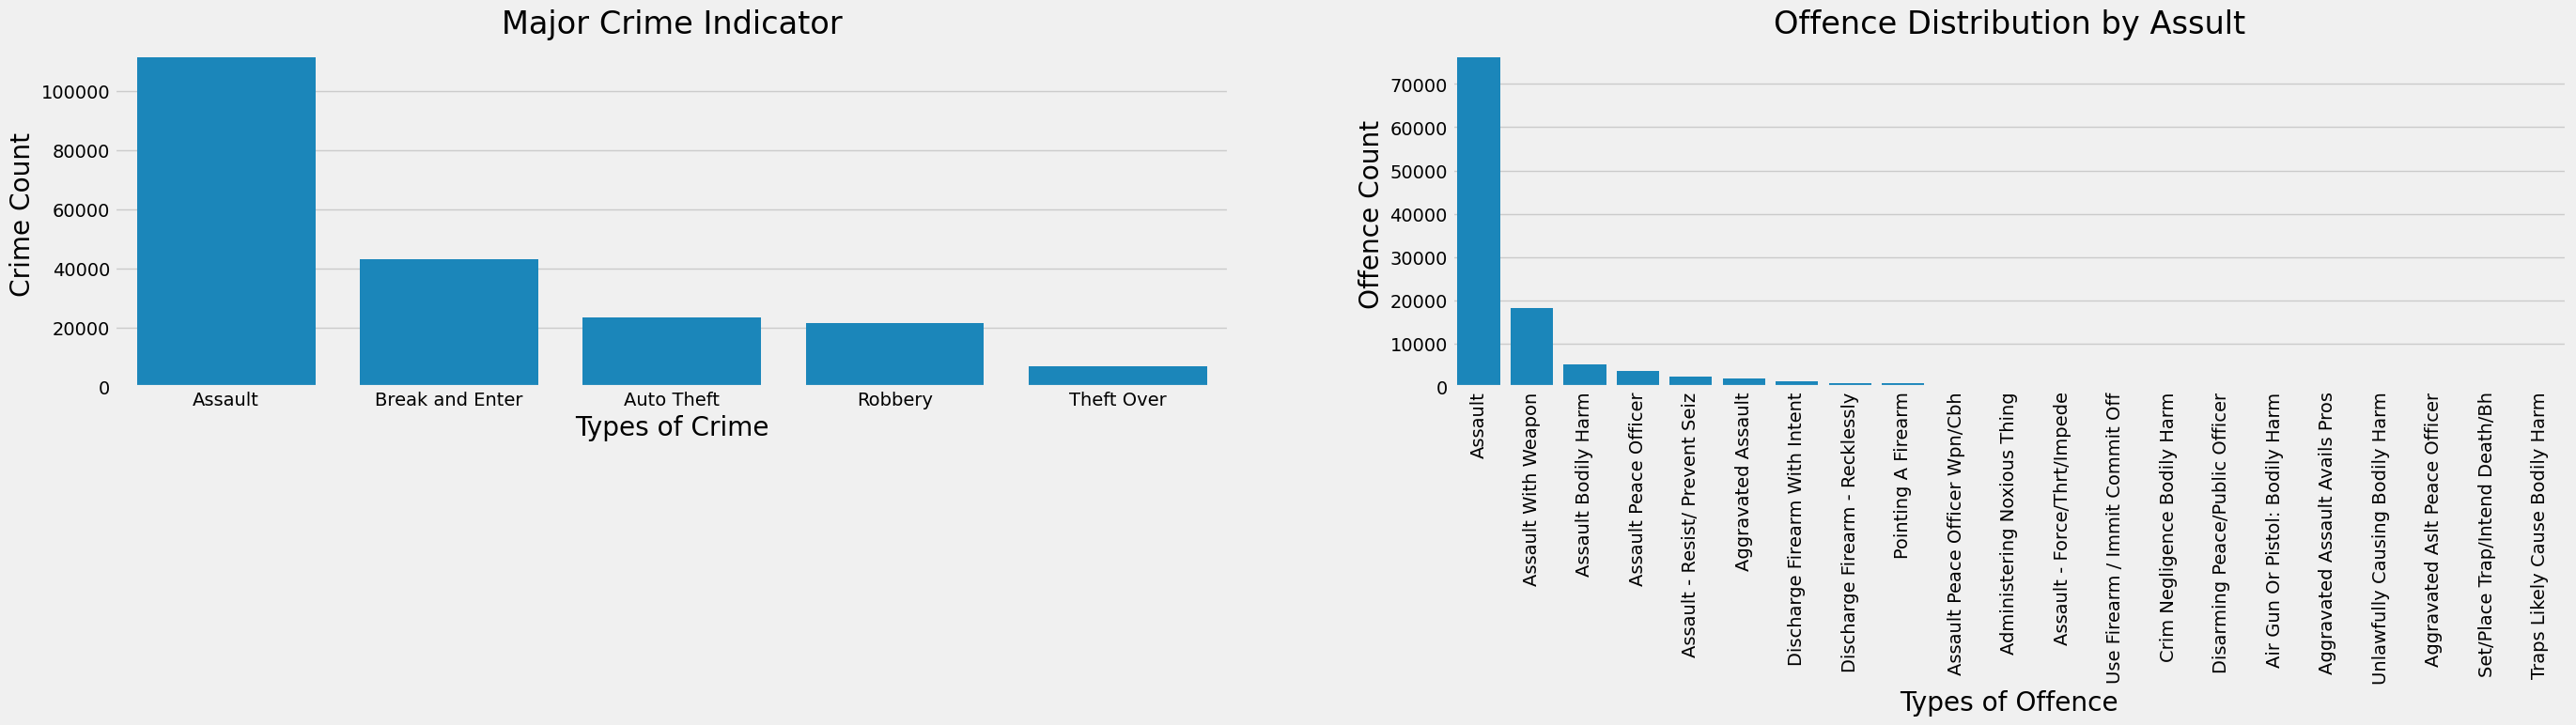

In [16]:
plt.figure(figsize=(30,10))
MCI= df.groupby('MCI',as_index=False).size()
assaultTypes= df[df.MCI=='Assault'].groupby('offence', as_index=False).size()
autoTheftTypes= df[df.MCI=='Auto Theft'].groupby('offence', as_index=False).size()

plt.subplot(221)
sns.barplot(x='MCI', y='size', data=MCI.sort_values(by='size', ascending=False))
plt.title('Major Crime Indicator', fontsize='xx-large')
plt.xlabel('Types of Crime', fontsize='x-large')
plt.ylabel('Crime Count', fontsize='x-large')

plt.subplot(222)
sns.barplot(x='offence', y='size', data=assaultTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Assult', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)



plt.show()

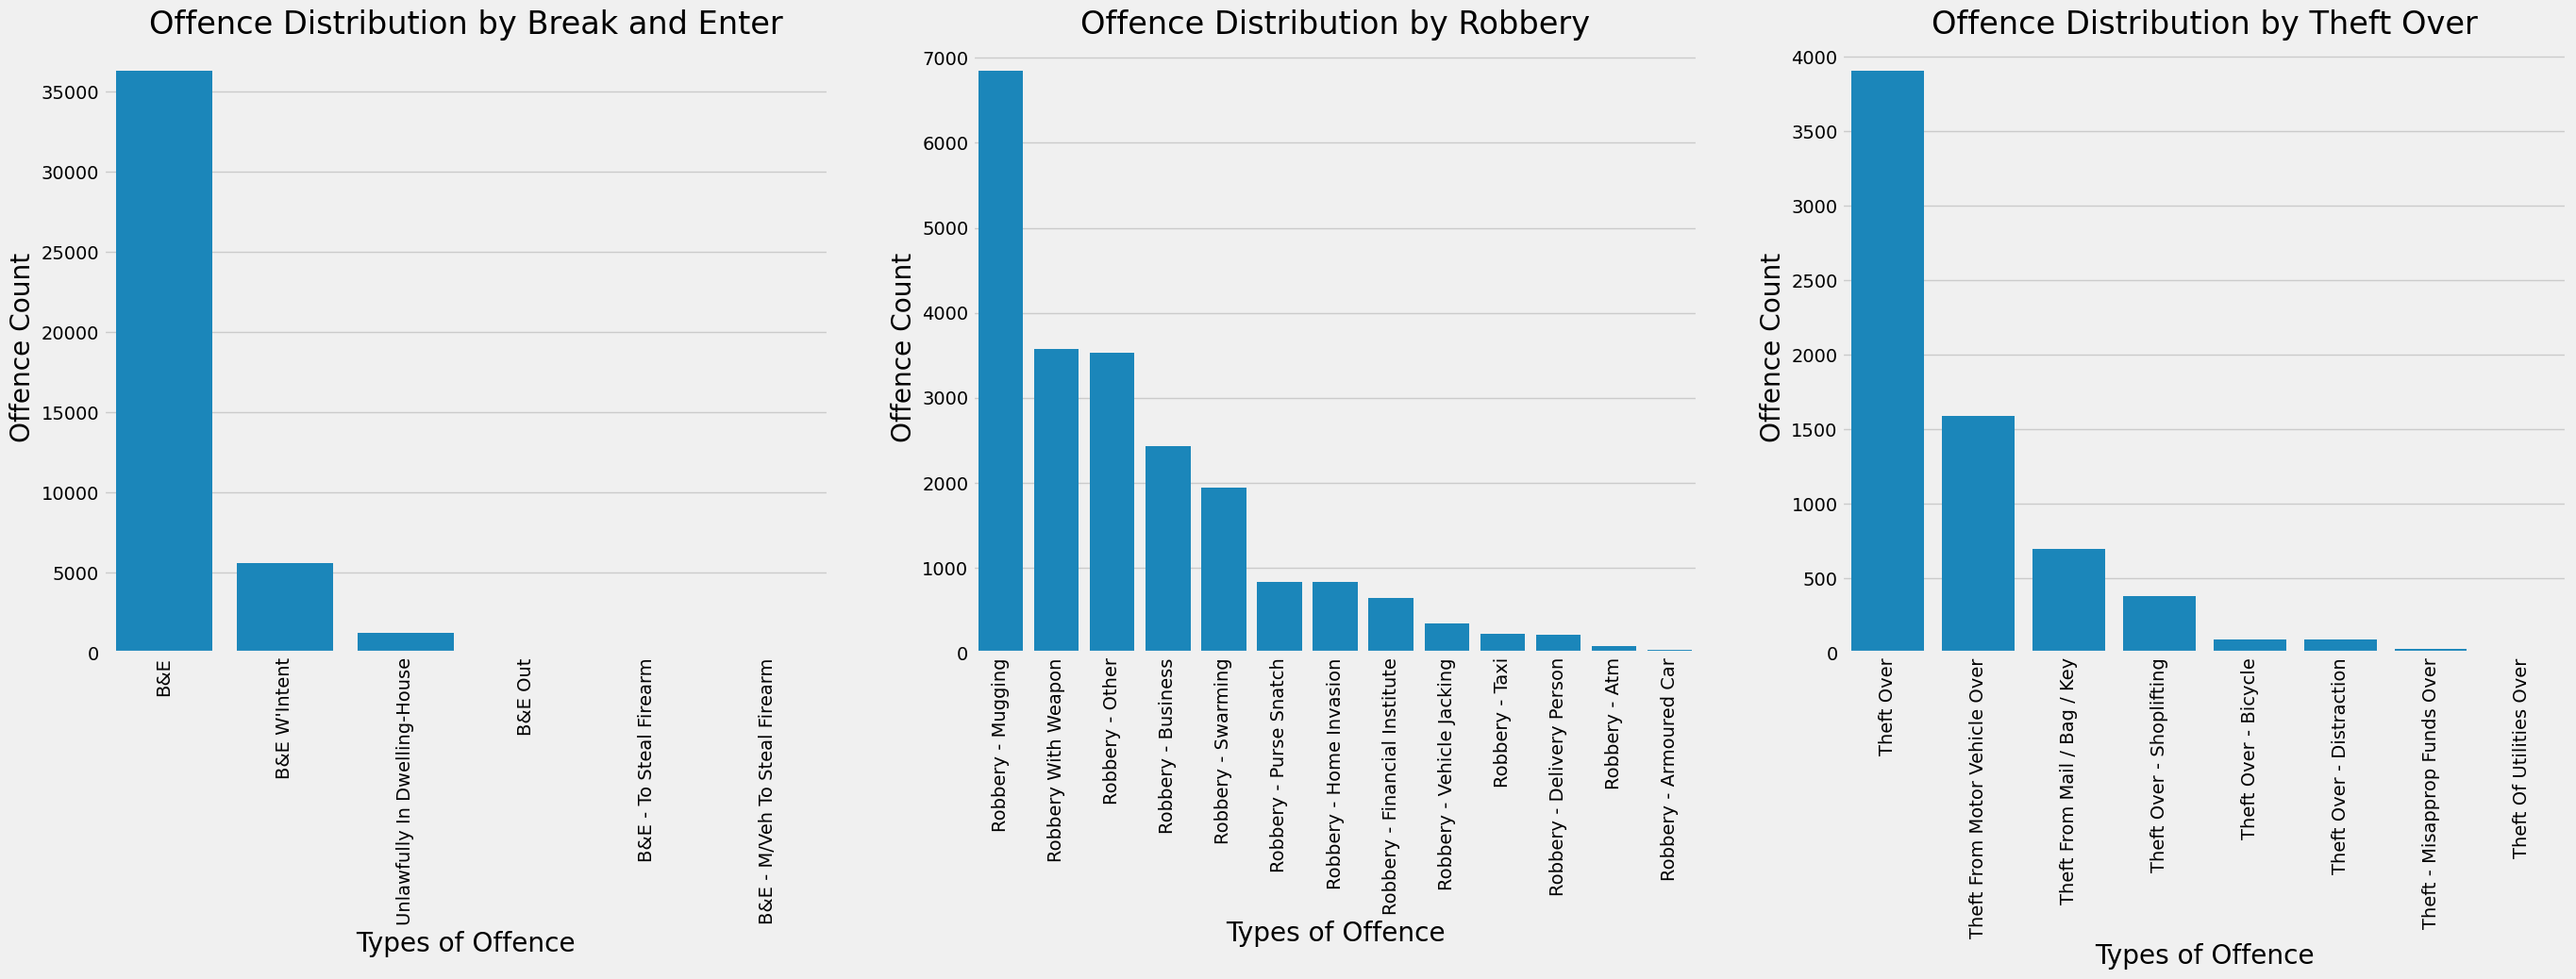

In [17]:
plt.figure(figsize=(30,8))

breakEnterTypes= df[df.MCI=='Break and Enter'].groupby('offence', as_index=False).size()
robberyTypes= df[df.MCI=='Robbery'].groupby('offence', as_index=False).size()
theftOverTypes= df[df.MCI=='Theft Over'].groupby('offence', as_index=False).size()

plt.subplot(131)
sns.barplot(x='offence', y='size', data=breakEnterTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Break and Enter', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.subplot(132)
sns.barplot(x='offence', y='size', data=robberyTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Robbery', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.subplot(133)
sns.barplot(x='offence', y='size', data=theftOverTypes.sort_values(by='size', ascending=False))
plt.title('Offence Distribution by Theft Over', fontsize='xx-large')
plt.xlabel('Types of Offence', fontsize='x-large')
plt.ylabel('Offence Count', fontsize='x-large')
plt.xticks(rotation=90)

plt.show()

In [18]:
df.reporteddate= pd.to_datetime(df.reporteddate)
df['reportOnlyDate']= df.reporteddate.dt.date
df.occurrencedate= pd.to_datetime(df.occurrencedate)
df['occurrenceOnlyDate']= df.occurrencedate.dt.date
df['delayInReporting'] = (df['reporteddate'] - df['occurrencedate']).dt.days

In [19]:
# **Time Series Forcasting** Problem and Multipath Approach
## Time Series Analysis for **Total Crime Count**

In [20]:
df['count']= 1
mci_monthwise = df.groupby(['occurrenceday','MCI'],as_index=False).agg({'count':'sum'})

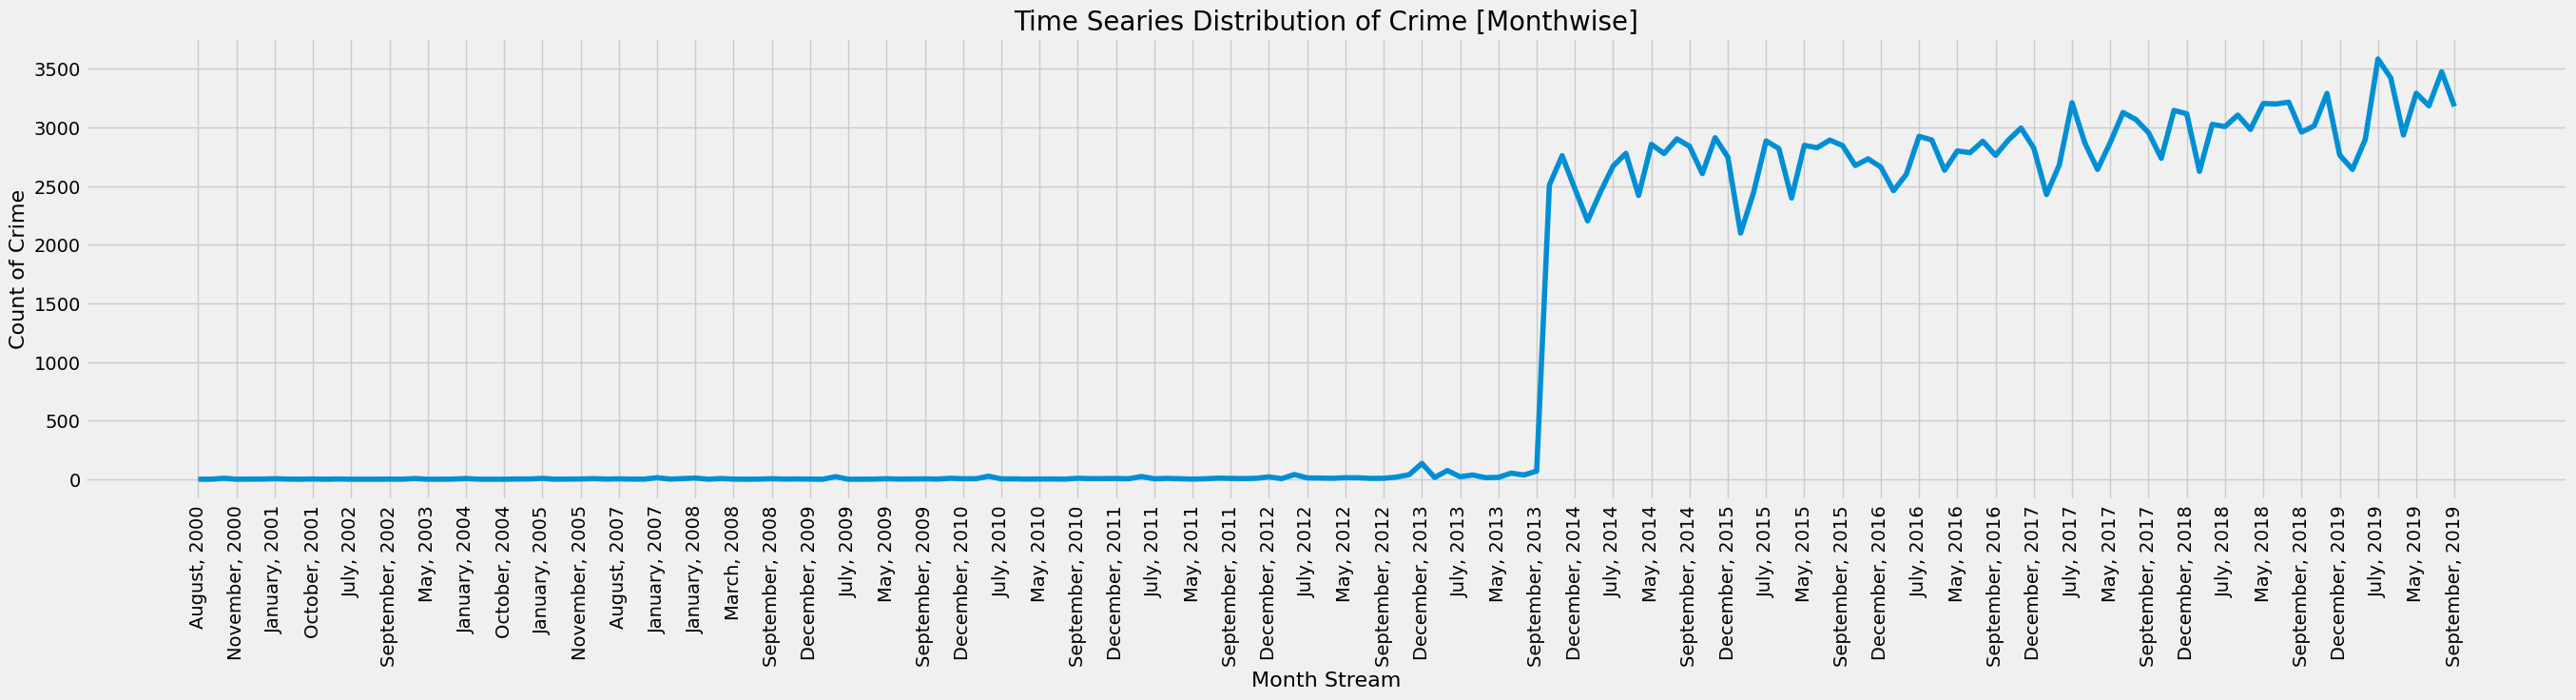

In [21]:
mci_distribution = df.groupby(['occurrenceyear','occurrencemonth'],as_index=False).agg({'count':'sum'})
mci_distribution['occurrenceyear']= mci_distribution['occurrenceyear'].astype('int').astype('str')
mci_distribution['monthYear']= mci_distribution['occurrencemonth'] +', '+ mci_distribution['occurrenceyear']

plt.grid('on')
plt.plot(mci_distribution['monthYear'], mci_distribution['count'])
plt.xlabel('Month Stream')
plt.ylabel('Count of Crime')
plt.title('Time Searies Distribution of Crime [Monthwise]')
plt.xticks(np.arange(0, mci_distribution['monthYear'].shape[0], 3), rotation=90)
plt.show()

In [22]:
occuranceDateVsMciCount= df.groupby(['occurrenceOnlyDate','MCI'],as_index=False).agg({'count':'sum'})
trimmedOccuranceDateVsMciCount= occuranceDateVsMciCount[occuranceDateVsMciCount.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()]

In [23]:
# occuranceDateCount= df.groupby(['occurrenceOnlyDate'],as_index=False).agg({'count':'sum'})
occuranceDateCount= df.groupby('occurrenceOnlyDate')['count'].sum().reset_index()
trimmedOccuranceDateCount= occuranceDateCount[occuranceDateCount.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()]
trimmedOccuranceDateCount['occurrenceOnlyDate']= pd.to_datetime(trimmedOccuranceDateCount.occurrenceOnlyDate)
trimmedOccuranceDateCount.set_index('occurrenceOnlyDate', inplace=True)

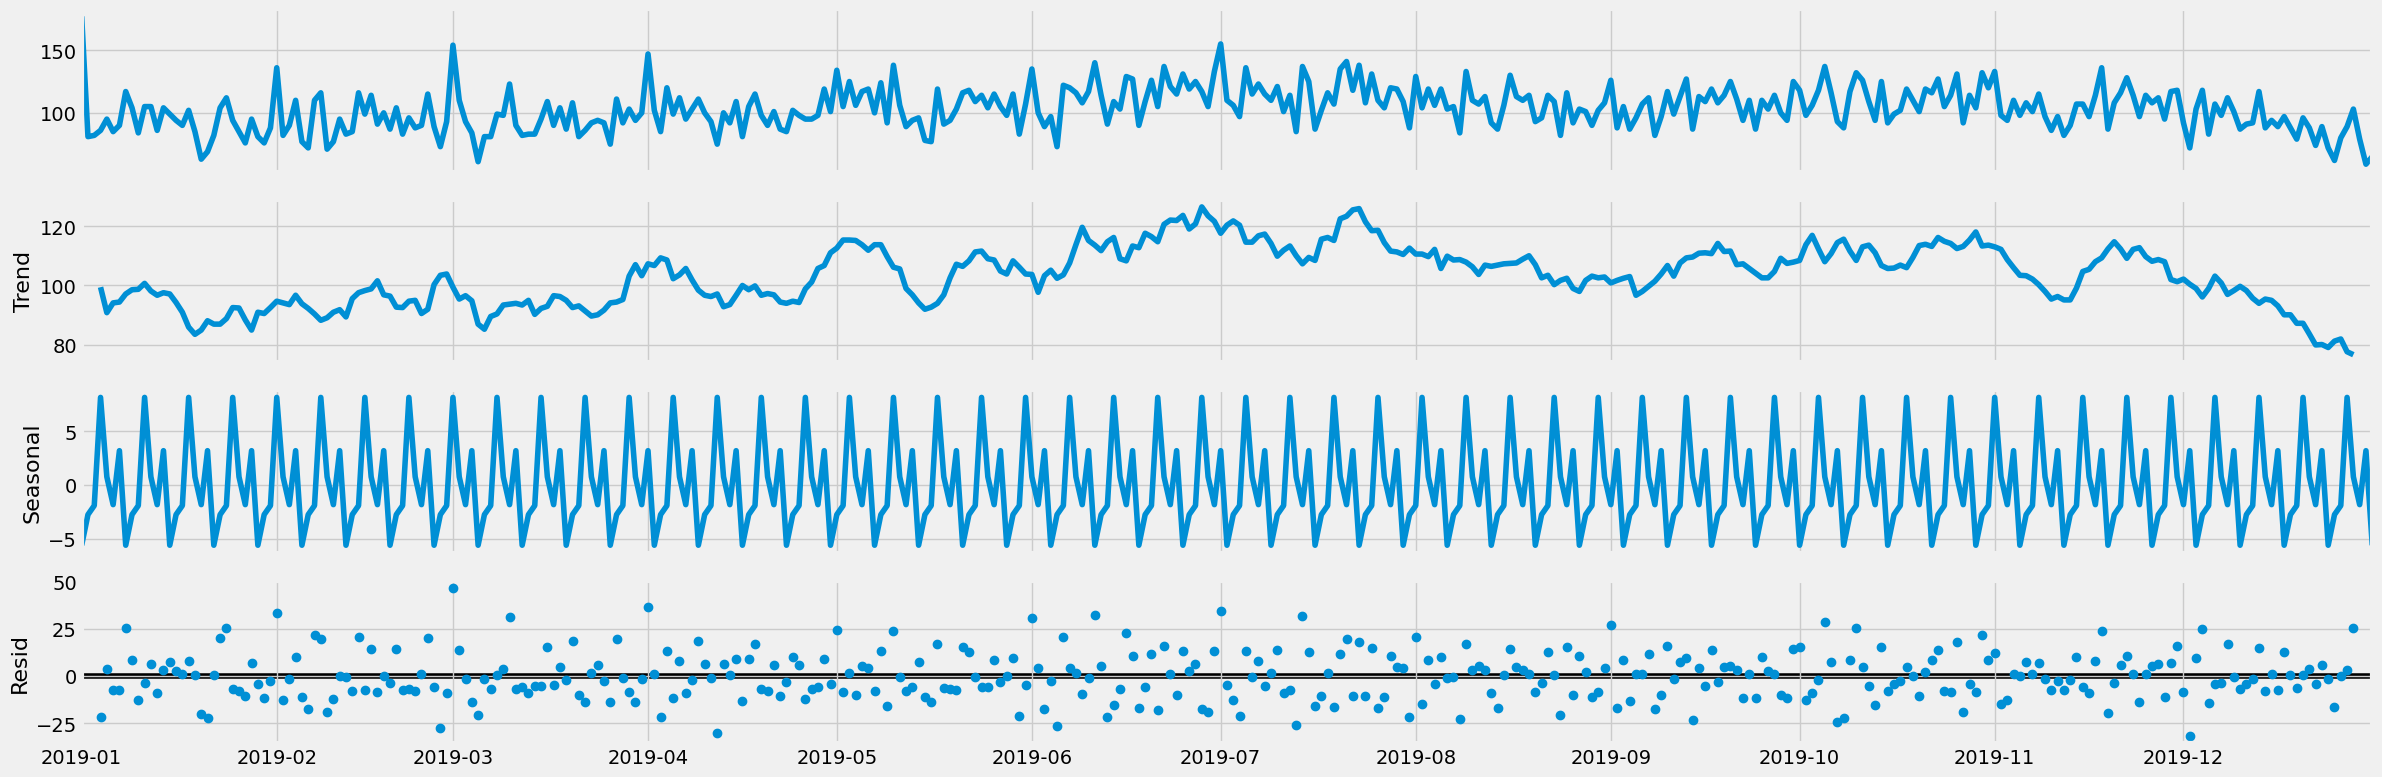

In [24]:
decomposition= sm.tsa.seasonal_decompose(trimmedOccuranceDateCount[trimmedOccuranceDateCount.index > pd.to_datetime('2018-12-31')], model='additive')

plt.rcParams['figure.figsize'] = 24, 8
decomposition.plot()

plt.show()

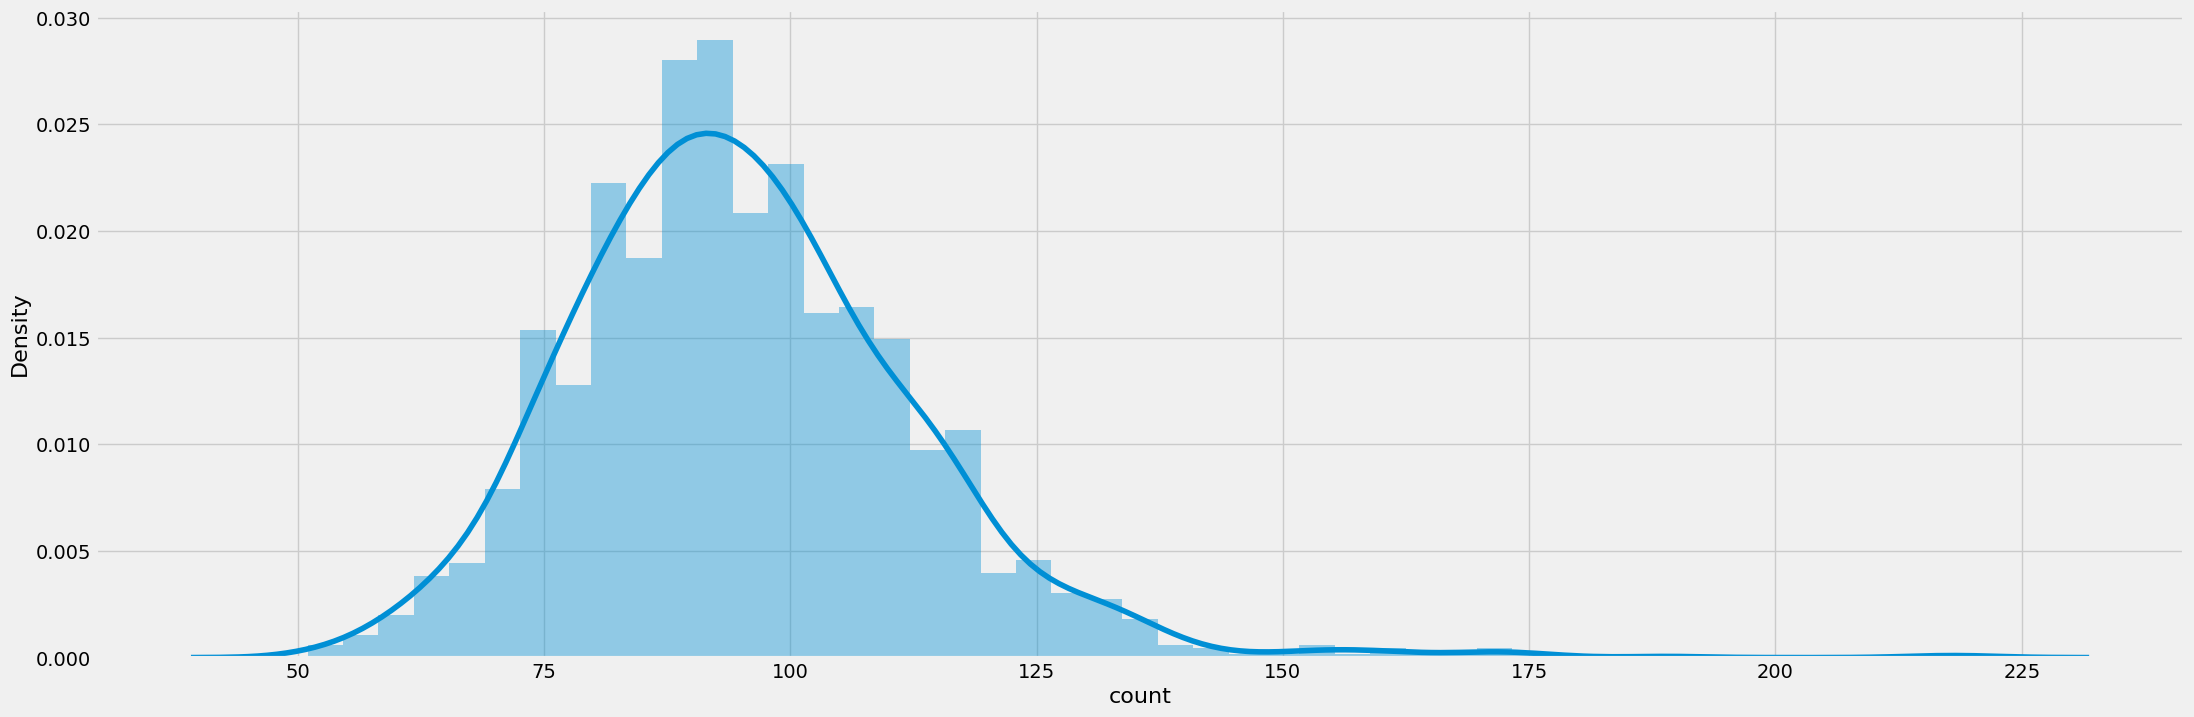

In [25]:
sns.distplot(trimmedOccuranceDateCount['count'])
plt.show()

In [26]:
trainData= trimmedOccuranceDateCount[trimmedOccuranceDateCount.index < pd.to_datetime('2018-12-31')]
testData= trimmedOccuranceDateCount[trimmedOccuranceDateCount.index > pd.to_datetime('2018-12-31')]

y= trimmedOccuranceDateCount['count'].resample('MS').mean()

In [27]:
## **SARIMA** Time Series Forcasting

In [28]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

resultDict= dict()

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod= sm.tsa.statespace.SARIMAX(trainData, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results= mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            resultDict['ARIMA{}x{}12'.format(param, param_seasonal)]= results.aic
        except:
            continue

minIndexARIMA= list(resultDict.keys())[(list(resultDict.values()).index(min(resultDict.values())))]
print('MIN INDEX: {}'.format(minIndexARIMA))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:17416.567419692547
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:15834.28930720771
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:13080.942401398419
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:12173.56633782788
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:13114.613248496138
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:12239.617844056636
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:12664.253674635018
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:12173.585890976678
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:15918.053941883983
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:14988.462581171832
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:13056.04538202997
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:12125.886753981558
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:13093.041693110295
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:12192.606356580147
ARIMA(0, 0, 1)x(1, 1, 

In [29]:
crimeforecast=results.forecast(steps=365)[0]
testData

,count
occurrenceOnlyDate,
2019-01-01,177
2019-01-02,81
2019-01-03,82
2019-01-04,86
2019-01-05,95
...,...
2019-12-27,89
2019-12-28,103
2019-12-29,79


In [30]:
SARIMAXmodel= sm.tsa.statespace.SARIMAX(trainData, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
SARIMAXresults= SARIMAXmodel.fit()
print(SARIMAXresults.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0994      0.025      3.964      0.000       0.050       0.149
ma.L1         -1.0365      0.008   -136.455      0.000      -1.051      -1.022
ma.S.L12      -1.0000     33.057     -0.030      0.976     -65.791      63.791
sigma2       234.1510   7740.601      0.030      0.976   -1.49e+04    1.54e+04


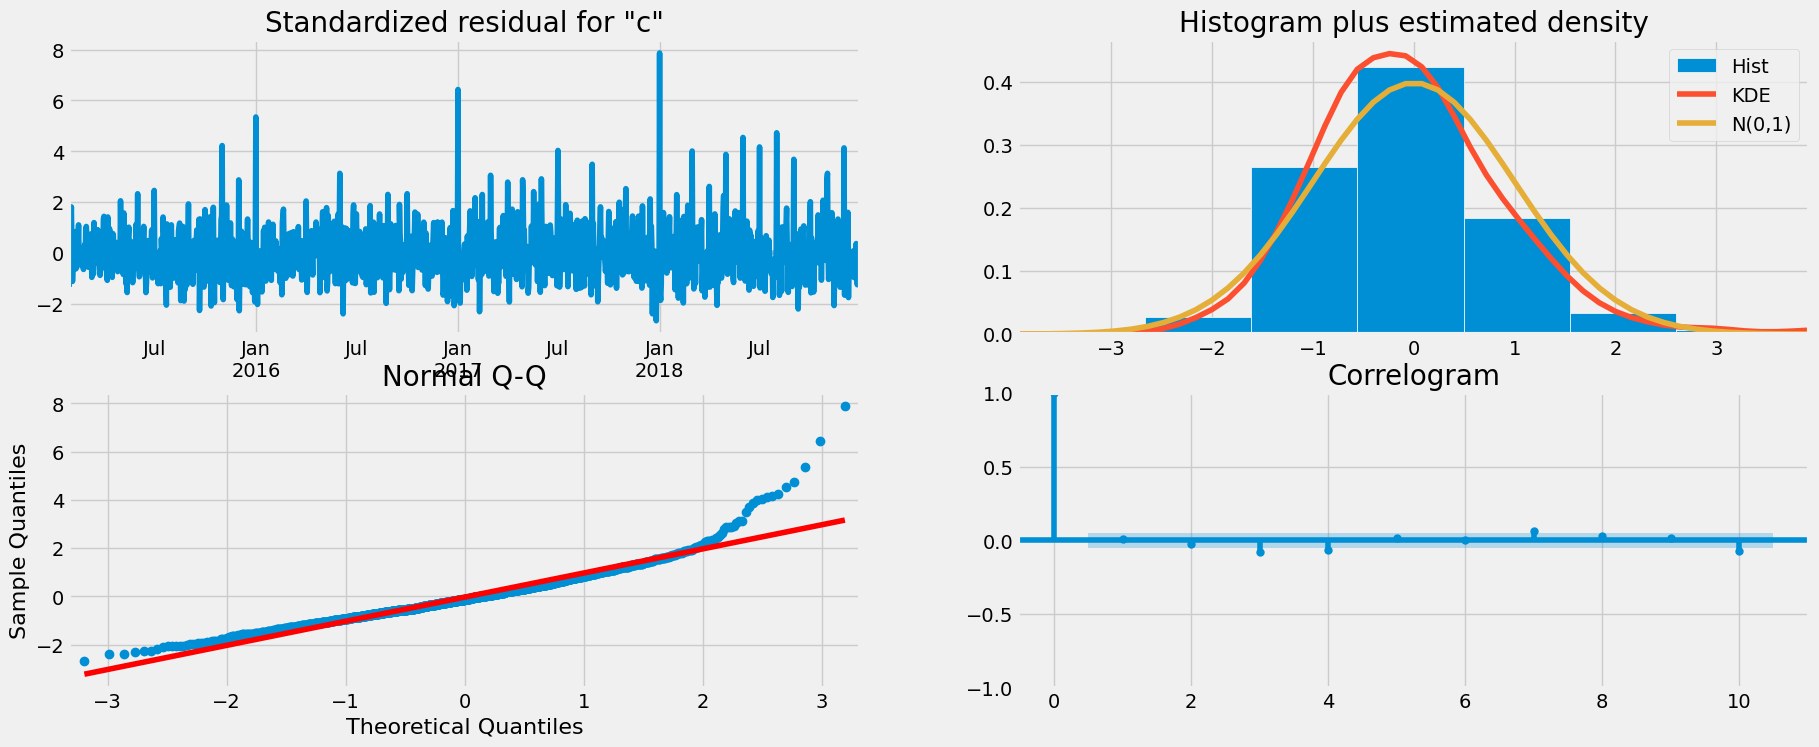

In [31]:
SARIMAXresults.plot_diagnostics(figsize=(20, 8))
plt.show()

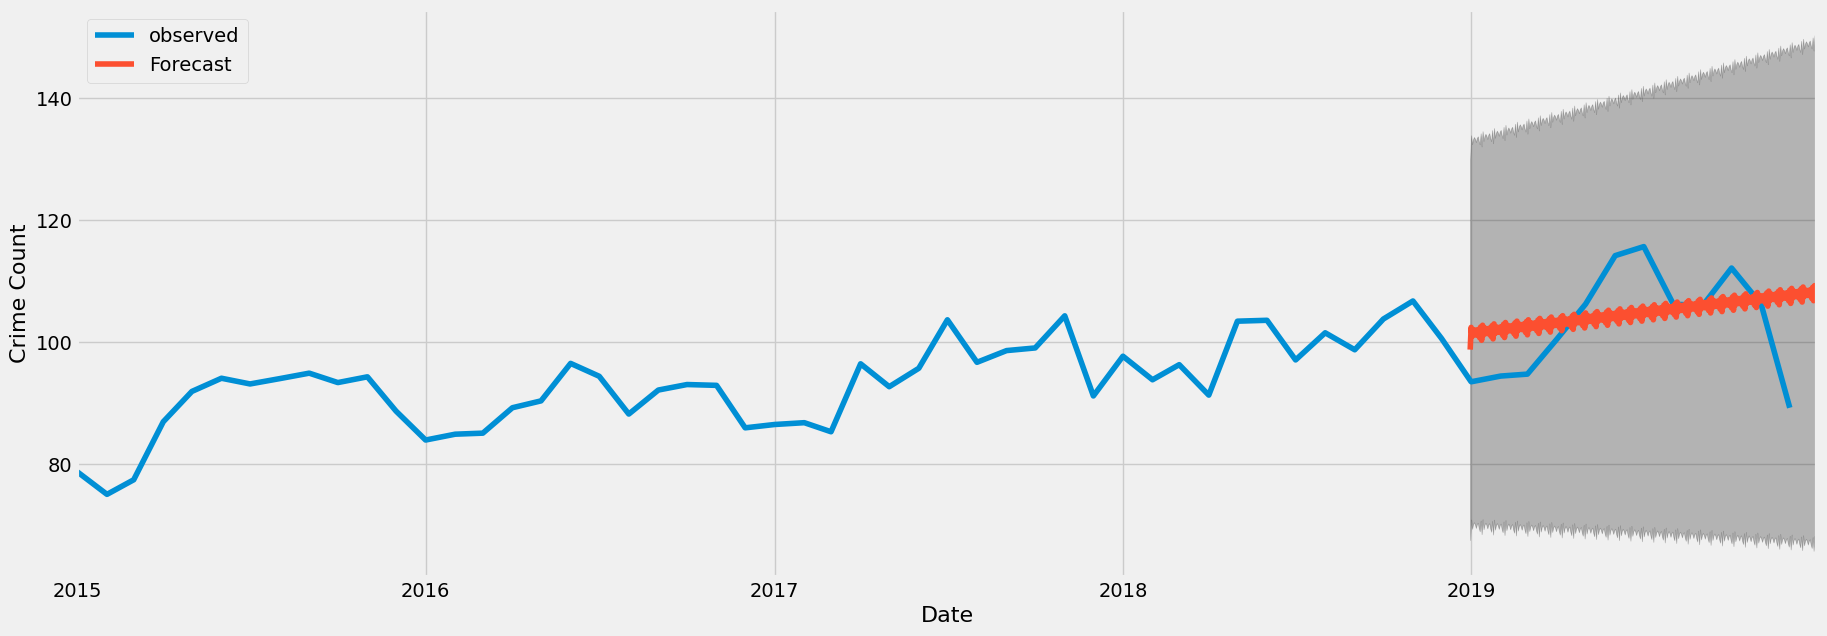

In [32]:
pred_uc= SARIMAXresults.get_forecast(steps=365)
pred_ci= pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(20, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Crime Count')
plt.legend()
plt.show()

In [33]:
testData['predValues']= pred_uc.predicted_mean.astype('int')

testData['lowerCount']= pred_ci[pred_ci.index >= testData.index.min()]['lower count']
testData['upperCount']= pred_ci[pred_ci.index >= testData.index.min()]['upper count']

mse= round(((testData['count'] - testData['predValues'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((testData['upperCount'] - testData['count'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((testData['lowerCount'] - testData['count'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))
print()
print(testData.head())

Mean Square Error: 285.83
Root Mean Square Error: 16.91
Mean Square Error with Upper Envelop: 1707.73
Root Mean Square Error with Upper Envelop: 41.32
Mean Square Error with Lower Envelop: 1503.55
Root Mean Square Error with Lower Envelop: 38.78

                    count  predValues  lowerCount  upperCount
occurrenceOnlyDate                                           
2019-01-01            177       102.0   70.838784  133.831624
2019-01-02             81       100.0   69.308982  132.374860
2019-01-03             82       101.0   70.064415  133.179834
2019-01-04             86       101.0   70.381296  133.544138
2019-01-05             95       101.0   70.029399  133.238222


In [34]:
## **Prophet** Time Series


In [35]:
trimmedOccuranceDateCountProphetFit= trainData.reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
prophet_model= Prophet(daily_seasonality=True)
prophet_model.fit(trimmedOccuranceDateCountProphetFit)

20:45:38 - cmdstanpy - INFO - Chain [1] start processing
20:45:38 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
prophetForecast= prophet_model.make_future_dataframe(periods=365)
prophetForecast= prophet_model.predict(prophetForecast)

<Figure size 1800x600 with 0 Axes>

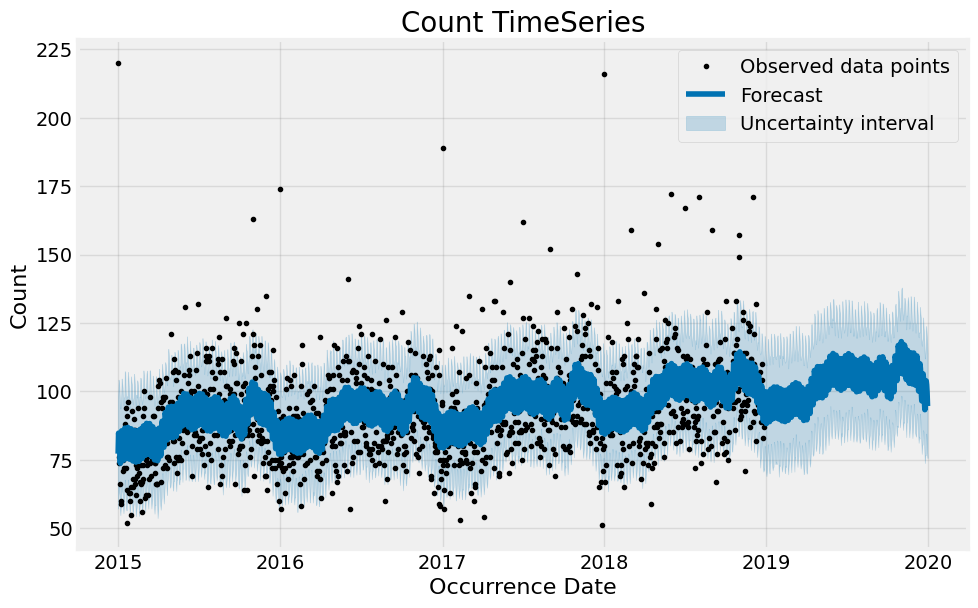

In [37]:
plt.figure(figsize=(18, 6))
prophet_model.plot(prophetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.legend()
plt.title('Count TimeSeries');

In [38]:
prophetForcast_yhat= prophetForecast[prophetForecast.ds >= pd.to_datetime('2019-01-01')].set_index('ds').loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
prophetForcast_trend= prophetForecast[prophetForecast.ds >= pd.to_datetime('2019-01-01')].set_index('ds').loc[:, ['trend', 'trend_lower', 'trend_upper']]
for _ in tqdm(prophetForcast_yhat.columns):
  prophetForcast_yhat[_]= prophetForcast_yhat[_].astype('int')
for _ in tqdm(prophetForcast_trend.columns):
  prophetForcast_trend[_]= prophetForcast_trend[_].astype('int')

100%|██████████| 3/3 [00:00<00:00, 7182.03it/s]


In [39]:
mse= round(((testData['count'] - prophetForcast_yhat['yhat'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_yhat['yhat_upper'] - testData['count'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_yhat['yhat_lower'] - testData['count'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet Complete yHat Data Error Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))
print()
print(prophetForcast_yhat.head())

Prophet Complete yHat Data Error Analysis

Mean Square Error: 249.12
Root Mean Square Error: 15.78
Mean Square Error with Upper Envelop: 601.9
Root Mean Square Error with Upper Envelop: 24.53
Mean Square Error with Lower Envelop: 676.3
Root Mean Square Error with Lower Envelop: 26.01

            yhat  yhat_lower  yhat_upper
ds                                      
2019-01-01    88          69         109
2019-01-02    90          70         110
2019-01-03    92          73         112
2019-01-04    99          80         119
2019-01-05    98          78         118


In [40]:
mse= round(((testData['predValues'] - prophetForcast_yhat['yhat'])**2).mean(), 2)
rmse= round(np.sqrt(mse), 2)
ubmse= round(((prophetForcast_yhat['yhat_upper'] - testData['upperCount'])**2).mean(), 2)
ubrmse= round(np.sqrt(ubmse), 2)
lbmse= round(((prophetForcast_yhat['yhat_lower'] - testData['lowerCount'])**2).mean(), 2)
lbrmse= round(np.sqrt(lbmse), 2)

print('Prophet vs ARIMA Forcasting Data Deviation Tendancy Analysis')
print()
print('Mean Square Error: {}'.format(mse))
print('Root Mean Square Error: {}'.format(rmse))
print('Mean Square Error with Upper Envelop: {}'.format(ubmse))
print('Root Mean Square Error with Upper Envelop: {}'.format(ubrmse))
print('Mean Square Error with Lower Envelop: {}'.format(lbmse))
print('Root Mean Square Error with Lower Envelop: {}'.format(lbrmse))

Prophet vs ARIMA Forcasting Data Deviation Tendancy Analysis

Mean Square Error: 35.84
Root Mean Square Error: 5.99
Mean Square Error with Upper Envelop: 384.77
Root Mean Square Error with Upper Envelop: 19.62
Mean Square Error with Lower Envelop: 249.54
Root Mean Square Error with Lower Envelop: 15.8


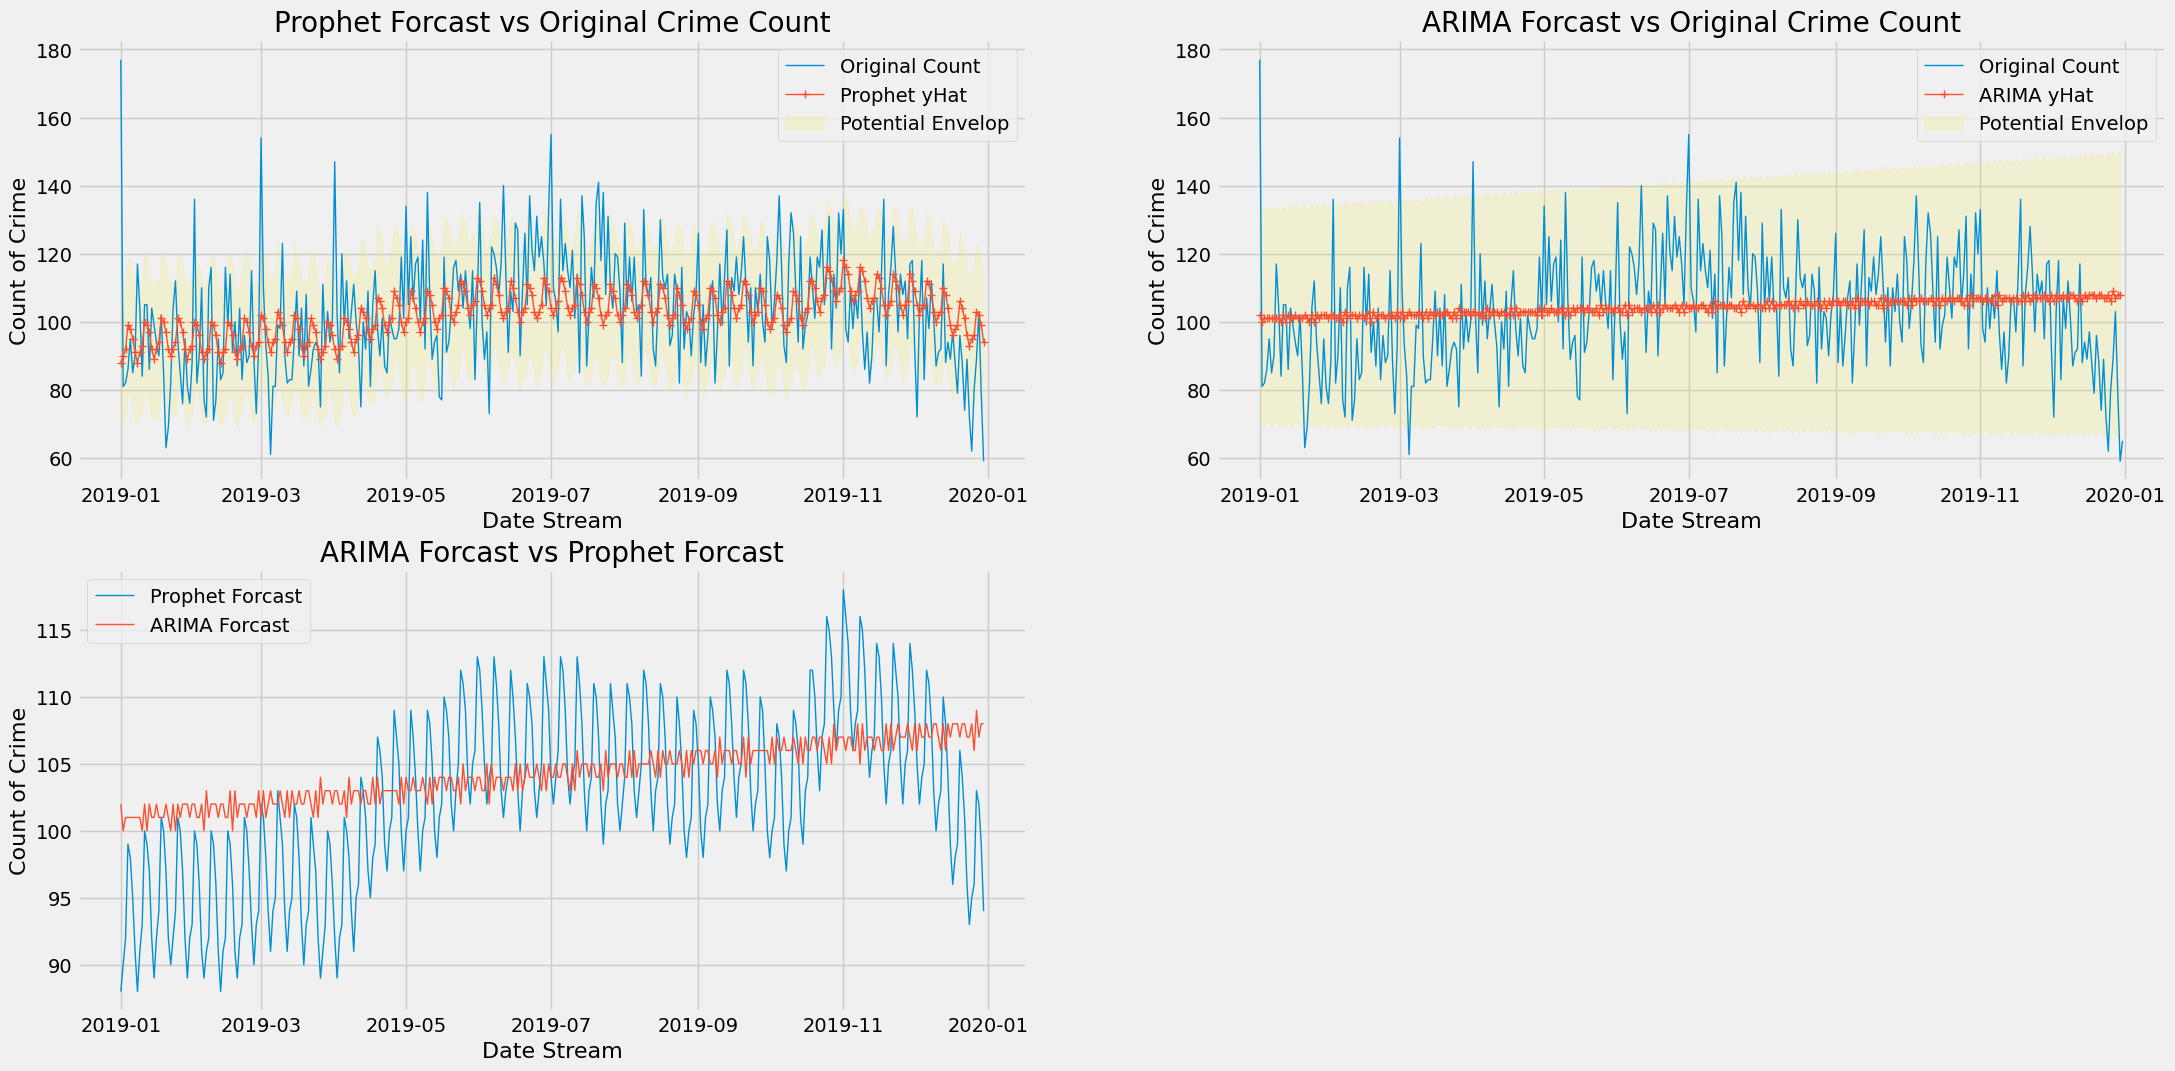

In [41]:
plt.rcParams['figure.figsize']= 24, 12

plt.subplot(221)
plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count')
plt.plot(prophetForcast_yhat.index, testData['count'].iloc[:-1], lw=1)
plt.plot(prophetForcast_yhat.index, prophetForcast_yhat['yhat'], lw=1, marker='+')
plt.fill_between(prophetForcast_yhat.index, prophetForcast_yhat['yhat_upper'], prophetForcast_yhat['yhat_lower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])


plt.subplot(222)
plt.grid('on')
plt.title('ARIMA Forcast vs Original Crime Count')
plt.plot(testData.index, testData['count'], lw=1)
plt.plot(testData.index, testData['predValues'], lw=1, marker='+')
plt.fill_between(testData.index, testData['upperCount'], testData['lowerCount'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'ARIMA yHat', 'Potential Envelop'])

plt.subplot(223)
plt.grid('on')
plt.title('ARIMA Forcast vs Prophet Forcast')
plt.plot(prophetForcast_yhat.index, prophetForcast_yhat['yhat'], lw=1)
plt.plot(testData.index[:-1], testData['predValues'][:-1], lw=1)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Prophet Forcast', 'ARIMA Forcast'])

plt.show()

In [42]:
print('Different Major Crime Indicators', end='\n\n')
for i, _ in enumerate(np.unique(df.MCI)):
  print('{}. {}'.format(i, _))

  mciDifferedResult= pd.DataFrame()

Different Major Crime Indicators

0. Assault
1. Auto Theft
2. Break and Enter
3. Robbery
4. Theft Over


20:45:39 - cmdstanpy - INFO - Chain [1] start processing
20:45:39 - cmdstanpy - INFO - Chain [1] done processing


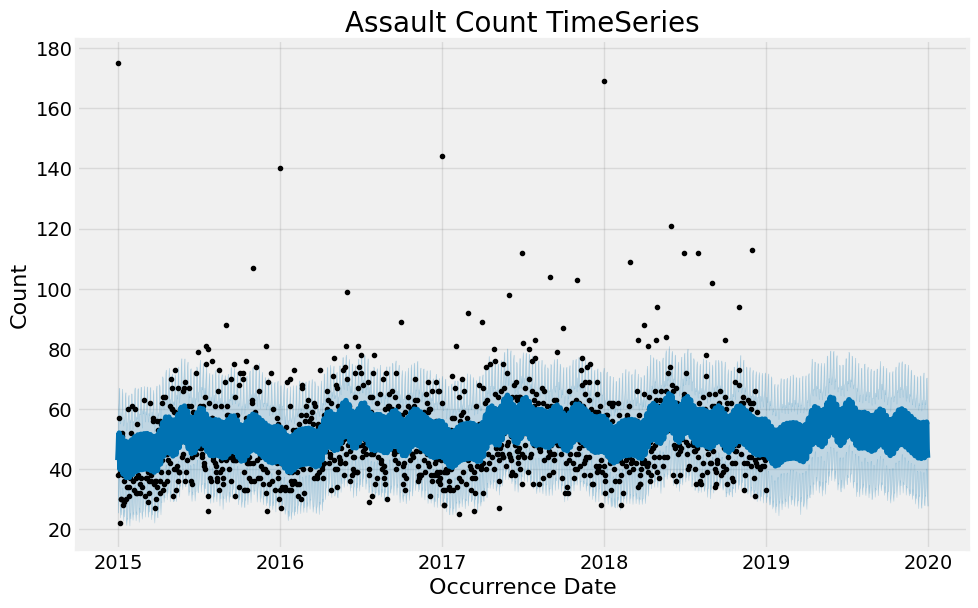

In [43]:
assaultTimewiseData= df[df.MCI == 'Assault'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
assaultTimewiseData= assaultTimewiseData[assaultTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()].reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
try:
  assaultTimewiseData.drop('index', axis=1, inplace=True)
except:
  pass

assaultProphetModel= Prophet(daily_seasonality=True).fit(assaultTimewiseData[assaultTimewiseData.ds < pd.to_datetime('2019-01-01').date()])
assaultProphetForecast= assaultProphetModel.make_future_dataframe(periods=365)
assaultProphetForecast= assaultProphetModel.predict(assaultProphetForecast)

assaultProphetModel.plot(assaultProphetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.title('Assault Count TimeSeries');

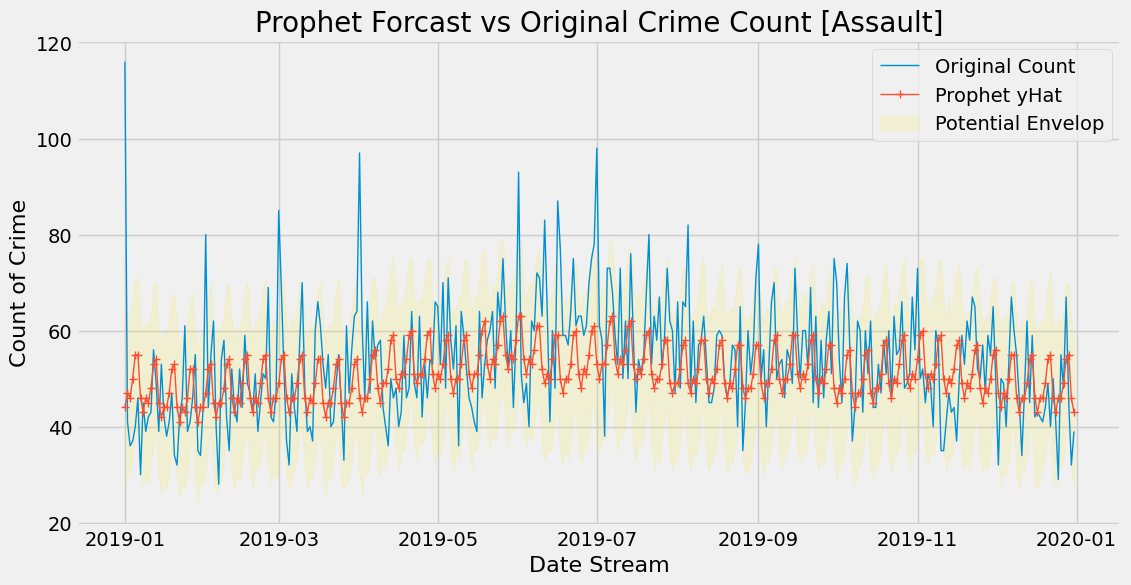

In [44]:
comparableData= assaultTimewiseData[assaultTimewiseData.ds >= pd.to_datetime('2019-01-01').date()]
comparableData['yhat']= assaultProphetForecast['yhat'].astype('int')
comparableData['yhatLower']= assaultProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper']= assaultProphetForecast['yhat_upper'].astype('int')

mciDifferedResult['Assault']= comparableData.yhat
mciDifferedResult['lower']= comparableData.yhatLower
mciDifferedResult['upper']= comparableData.yhatUpper

plt.rcParams['figure.figsize']= 12,6

plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()

20:45:39 - cmdstanpy - INFO - Chain [1] start processing
20:45:40 - cmdstanpy - INFO - Chain [1] done processing


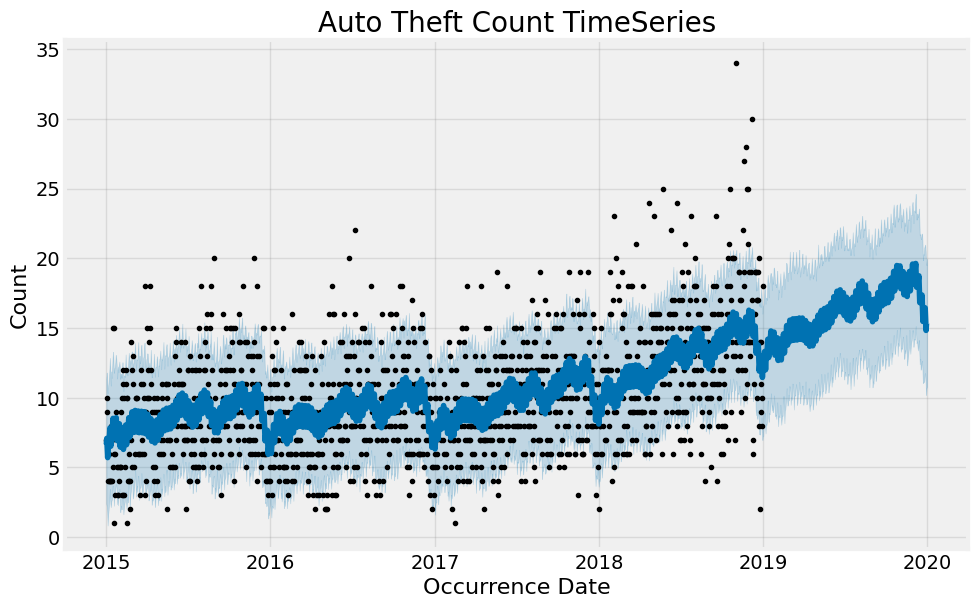

In [45]:
autoTheftTimewiseData= df[df.MCI == 'Auto Theft'].groupby('occurrenceOnlyDate')['count'].sum().reset_index()
autoTheftTimewiseData= autoTheftTimewiseData[autoTheftTimewiseData.occurrenceOnlyDate > pd.to_datetime('2014-12-31').date()].reset_index().rename(columns={'occurrenceOnlyDate': 'ds', 'count': 'y'})
try:
  autoTheftTimewiseData.drop('index', axis=1, inplace=True)
except:
  pass

autoTheftProphetModel= Prophet(daily_seasonality=True).fit(autoTheftTimewiseData[autoTheftTimewiseData.ds < pd.to_datetime('2019-01-01').date()])
autoTheftProphetForecast= autoTheftProphetModel.make_future_dataframe(periods=365)
autoTheftProphetForecast= autoTheftProphetModel.predict(autoTheftProphetForecast)


autoTheftProphetModel.plot(autoTheftProphetForecast, xlabel = 'Occurrence Date', ylabel = 'Count')
plt.title('Auto Theft Count TimeSeries');

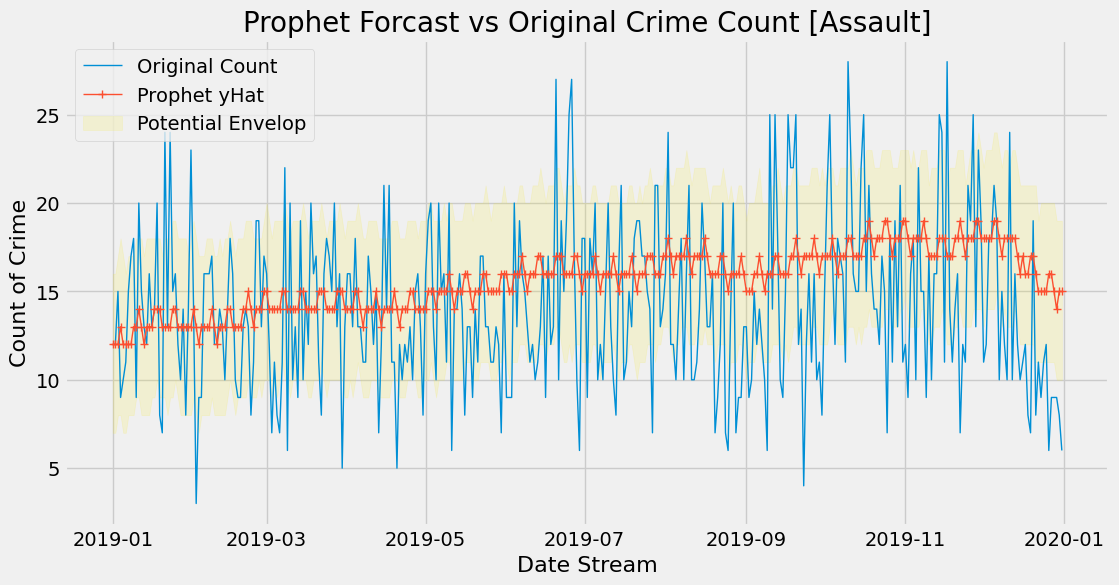

In [46]:
comparableData= autoTheftTimewiseData[autoTheftTimewiseData.ds >= pd.to_datetime('2019-01-01').date()]
comparableData['yhat']= autoTheftProphetForecast['yhat'].astype('int')
comparableData['yhatLower']= autoTheftProphetForecast['yhat_lower'].astype('int')
comparableData['yhatUpper']= autoTheftProphetForecast['yhat_upper'].astype('int')

mciDifferedResult['AutoTheft']= comparableData.yhat
mciDifferedResult['lower']= mciDifferedResult['lower'] + comparableData.yhatLower
mciDifferedResult['upper']= mciDifferedResult['upper'] + comparableData.yhatUpper


plt.grid('on')
plt.title('Prophet Forcast vs Original Crime Count [Assault]')
plt.plot(comparableData.ds, comparableData['y'], lw=1)
plt.plot(comparableData.ds, comparableData['yhat'], lw=1, marker='+')
plt.fill_between(comparableData.ds, comparableData['yhatUpper'], comparableData['yhatLower'], color='#f7ed25', alpha=.15)
plt.xlabel('Date Stream')
plt.ylabel('Count of Crime')
plt.legend(['Original Count', 'Prophet yHat', 'Potential Envelop'])
plt.show()

#### END

In [68]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Load the dataset
df = pd.read_csv('data/MCI_2014_to_2019.csv')

# Preprocessing
df['occurrencedate'] = pd.to_datetime(df['occurrencedate'])
features = ['occurrencedate', 'offence', 'Division', 'Neighbourhood']
df = df[features]

# Encode categorical features
le = LabelEncoder()
df['offence'] = le.fit_transform(df['offence'])
df['Division'] = le.fit_transform(df['Division'])
df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])

# Sort by date
df.sort_values('occurrencedate', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
df[['offence', 'Division', 'Neighbourhood']] = scaler.fit_transform(df[['offence', 'Division', 'Neighbourhood']])

# Create sequences for time-series model
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predicting 'offence'
    return np.array(X), np.array(y)

X, y = create_sequences(df[['offence', 'Division', 'Neighbourhood']].values)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, y_train = torch.FloatTensor(X_train).to(device), torch.LongTensor(y_train).to(device)
X_test, y_test = torch.FloatTensor(X_test).to(device), torch.LongTensor(y_test).to(device)

# LSTM Model
class CrimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CrimeLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take the last output
        return out

# Hyperparameters
input_size = X_train.shape[2]
hidden_size = 64
output_size = len(np.unique(y))

# Initialize the model
lstm_model = CrimeLSTM(input_size, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training the LSTM model
num_epochs = 50
for epoch in range(num_epochs):
    lstm_model.train()
    optimizer_lstm.zero_grad()
    outputs = lstm_model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer_lstm.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the LSTM model
lstm_model.eval()
with torch.no_grad():
    y_pred = lstm_model(X_test)
    y_pred_classes = torch.argmax(y_pred, axis=1)
    lstm_acc = accuracy_score(y_test.cpu(), y_pred_classes.cpu())
    lstm_precision = precision_score(y_test.cpu(), y_pred_classes.cpu(), average='weighted')
    lstm_recall = recall_score(y_test.cpu(), y_pred_classes.cpu(), average='weighted')
    print("LSTM Accuracy:", lstm_acc)
    print("LSTM Precision:", lstm_precision)
    print("LSTM Recall:", lstm_recall)

# GRU Model
class CrimeGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CrimeGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])  # Take the last output
        return out

# Initialize the GRU model
gru_model = CrimeGRU(input_size, hidden_size, output_size).to(device)

# Train the GRU model
optimizer_gru = optim.Adam(gru_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    gru_model.train()
    optimizer_gru.zero_grad()
    outputs = gru_model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer_gru.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the GRU model
gru_model.eval()
with torch.no_grad():
    y_pred_gru = gru_model(X_test)
    y_pred_gru_classes = torch.argmax(y_pred_gru, axis=1)
    gru_acc = accuracy_score(y_test.cpu(), y_pred_gru_classes.cpu())
    gru_precision = precision_score(y_test.cpu(), y_pred_gru_classes.cpu(), average='weighted')
    gru_recall = recall_score(y_test.cpu(), y_pred_gru_classes.cpu(), average='weighted')
    print("GRU Accuracy:", gru_acc)
    print("GRU Precision:", gru_precision)
    print("GRU Recall:", gru_recall)

# Compare model performances
print(f"LSTM Accuracy: {lstm_acc:.4f}, Precision: {lstm_precision:.4f}, Recall: {lstm_recall:.4f}")
print(f"GRU Accuracy: {gru_acc:.4f}, Precision: {gru_precision:.4f}, Recall: {gru_recall:.4f}")

Epoch [10/50], Loss: 3.6377
Epoch [20/50], Loss: 3.1726
Epoch [30/50], Loss: 1.3562
Epoch [40/50], Loss: 0.1963
Epoch [50/50], Loss: 0.0474
LSTM Accuracy: 0.9994913406806346
LSTM Precision: 0.9989829400955724
LSTM Recall: 0.9994913406806346
Epoch [10/50], Loss: 3.4893
Epoch [20/50], Loss: 2.8654
Epoch [30/50], Loss: 0.9452
Epoch [40/50], Loss: 0.0684
Epoch [50/50], Loss: 0.0243
GRU Accuracy: 0.9994913406806346
GRU Precision: 0.9989829400955724
GRU Recall: 0.9994913406806346
LSTM Accuracy: 0.9995, Precision: 0.9990, Recall: 0.9995
GRU Accuracy: 0.9995, Precision: 0.9990, Recall: 0.9995
